<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Explore_BatchTransformsCPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# colab
# !curl -s https://course.fast.ai/setup/colab | bash

In [ ]:
# colab
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#colab
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#colab
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [1]:
# colab
# !pip install fastai2 --upgrade > /dev/null
!pip freeze | grep fastai2

-e git+https://github.com/fastai/fastai2@ce795166a8b22fff7cdd6ae4e4e8e1b9356d33c3#egg=fastai2


In [2]:
#colab
# !pip install git+https://github.com/butchland/fastai_xla_extensions > /dev/null
!pip freeze | grep fastai_xla_extensions

-e git+git@github.com:butchland/fastai_xla_extensions.git@f73e3b0c6cc4e38475c8a8959274ae6b37da11d0#egg=fastai_xla_extensions


In [3]:
#colab
# !pip install git+https://github.com/butchland/my_timesaver_utils > /dev/null
!pip freeze | grep my_timesaver_utils

-e git+git@github.com:butchland/my_timesaver_utils.git@ceccd07e7c70befbe3579fd1b77e8c2cbd8e61ce#egg=my_timesaver_utils


### Import Libraries

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from fastai_xla_extensions.core import *

In [6]:
from fastai2.vision.all import *

In [7]:
from my_timesaver_utils.profiling import *

### Setup data

In [8]:
path = untar_data(URLs.PETS)/'images'

### Loop through batch and walk through batch transforms

In [9]:
# from IPython.core.debugger import set_trace

In [10]:
# TRACE = True

In [ ]:
# orig_randtransform_call = RandTransform.__call__
# def __call__(self, b, split_idx=None, **kwargs):
#     is_affine_tfm = isinstance(self, AffineCoordTfm)
#     if is_affine_tfm:
# #         print(f'applying AffineCoordTfm call {self}')
# #         if TRACE: set_trace()
#         start_record('affine_tfm_call')
#     results = orig_randtransform_call(self, b, split_idx, **kwargs)
#     if is_affine_tfm:
#         end_record('affine_tfm_call')
#     return results

In [ ]:
# setattr(RandTransform,'__call__', __call__)

In [ ]:
# def mycompose_tfms(x, tfms, is_enc=True, reverse=False, **kwargs):
#     "Apply all `func_nm` attribute of `tfms` on `x`, maybe in `reverse` order"
#     if reverse: tfms = reversed(tfms)
#     for f in tfms:
#         if not is_enc: f = f.decode
#         if isinstance(f,AffineCoordTfm): 
#             print(f'applying {type(f)} {f} to {type(x)}')
#             if TRACE:
#                 set_trace()
#         x = f(x, **kwargs)
#     return x


In [ ]:
# @patch_to(Pipeline)
# def __call__(self, o): return mycompose_tfms(o, tfms=self.fs, split_idx=self.split_idx)

In [ ]:
# TRACE = False

In [43]:
batch_tfms = aug_transforms(max_zoom=1.0, max_warp=0., max_rotate=0., max_lighting=0.0,do_flip=True, flip_vert = False)
batch_tfms

[AffineCoordTfm: (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes ]

In [44]:
batch_tfms[0].aff_fs

(#1) [functools.partial(<function flip_mat at 0x13acd25f0>, p=0.5, draw=None, batch=False)]

In [45]:
batch_tfms[0].coord_fs

(#0) []

In [14]:
pat = r'(.+)_\d+.jpg$'

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [15]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(pat),'name'),
    item_tfms=Resize(224),
    batch_tfms=[]
   
)

In [16]:
print_prof_data()

In [17]:
datablock.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/butch/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize
    starting from
      /Users/butch/.fastai/data/oxford-iiit-pet/images/saint_bernard_60.jpg
    applying partial gives
      saint_bernard
    applying Categorize gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(30))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=375x500, TensorCategory(30))
    applying Resi

In [18]:
print_prof_data()

### Setup DataLoaders

In [19]:
bs=64

In [20]:
dls = datablock.dataloaders(path,bs=bs)

In [21]:
dls.train

In [22]:
train_dl = dls.train

In [23]:
dir(train_dl)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_after_item',
 '_call',
 '_component_attr_filter',
 '_component_attr_filter',
 '_dbunch_type',
 '_dbunch_type',
 '_decode_batch',
 '_default',
 '_default',
 '_dir',
 '_dir',
 '_dl_type',
 '_dl_type',
 '_do_call',
 '_docs',
 '_get',
 '_is_showable',
 '_methods',
 '_n_inp',
 '_name',
 '_new',
 '_new',
 '_newchk',
 '_noop_methods',
 '_one_pass',
 '_pre_show_batch',
 '_retain_dl',
 '_types',
 'add',
 'add_na',
 'after_batch',
 'after_batch',
 'after_item',
 'after_item',
 'after_iter',
 'append',
 'argwhere',
 'attrgot',
 'before_batch',
 'before_batch',
 'before_iter

In [24]:
dl_iter = train_dl.__iter__()

In [25]:
type(dl_iter)

generator

In [27]:
b = dl_iter.__next__()

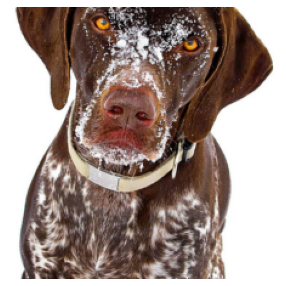

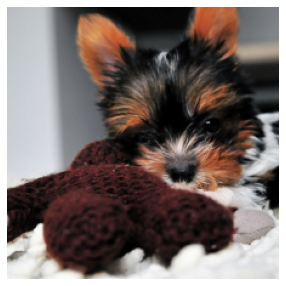

In [36]:
show_image(b[0][2]);show_image(b[0][0]);

In [39]:
b0 = b[0];(b0.shape,b0.device)

(torch.Size([64, 3, 224, 224]), device(type='cpu'))

In [ ]:
flip_tfm = 

In [ ]:
# def fetch_one_batch():
#     if TRACE: set_trace()
#     dl_iter = train_dl.__iter__()
#     b = dl_iter.__next__()

In [ ]:
# TRACE = False

In [ ]:
clear_prof_data();print_prof_data()

In [ ]:
# fetch_one_batch()

In [ ]:
# print_prof_data()

In [ ]:
clear_prof_data(); print_prof_data()

In [ ]:
def fetch_all_batches():
    for b in train_dl:
        pass

In [ ]:
fetch_all_batches()

In [ ]:
print_prof_data()

In [ ]:
times = get_prof_data('affine_tfm_call')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
times

In [ ]:
plt.plot(times);

In [ ]:
dls.device

In [ ]:
train_dl.device